Financial market has always been know as volatile and hard to predict. As a finance major student, how to better predict the change in stocks market has always intrigued me. 

Here, I compared traditional statistical ways to predict (Standard Average & Exponential Moving Average) as well as more complex machine learning model(LSTM) to extract patterns behind the time series data.

The dataset can be found on Kaggle: https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/data

I run this on Google Colab. The features I used are: Date, Open, High, Low, Close, Volume. The main objective of this project is to practice the LSTM model by looking at the history of a sequence of data and correctly predict the results of the sequence in the different time period in future.

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data
import datetime as dt
import urllib.request, json
import os
import time
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [3]:
# ran on Google Colab
from google.colab import files
uploaded = files.upload()

Saving hpq.us.txt to hpq.us.txt


In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['hpq.us.txt']), usecols=['Date','Open','High','Low','Close','Volume'])
# Dataset is now stored in a Pandas Dataframe

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1970-01-02,0.30627,0.30627,0.30627,0.30627,2441124
1,1970-01-05,0.30627,0.31768,0.30627,0.31385,6219848
2,1970-01-06,0.31385,0.31385,0.30996,0.30996,4447522
3,1970-01-07,0.31385,0.31385,0.31385,0.31385,1872638
4,1970-01-08,0.31385,0.31768,0.31385,0.31385,4280330


In [6]:
#df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'), delimiter=',',
 #                 usecols=['Date','Open','High','Low','Close','Volume'])

df = df.sort_values('Date')

df.head()

,Date,Open,High,Low,Close,Volume
0,1970-01-02,0.30627,0.30627,0.30627,0.30627,2441124
1,1970-01-05,0.30627,0.31768,0.30627,0.31385,6219848
2,1970-01-06,0.31385,0.31385,0.30996,0.30996,4447522
3,1970-01-07,0.31385,0.31385,0.31385,0.31385,1872638
4,1970-01-08,0.31385,0.31768,0.31385,0.31385,4280330


In [7]:
df.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

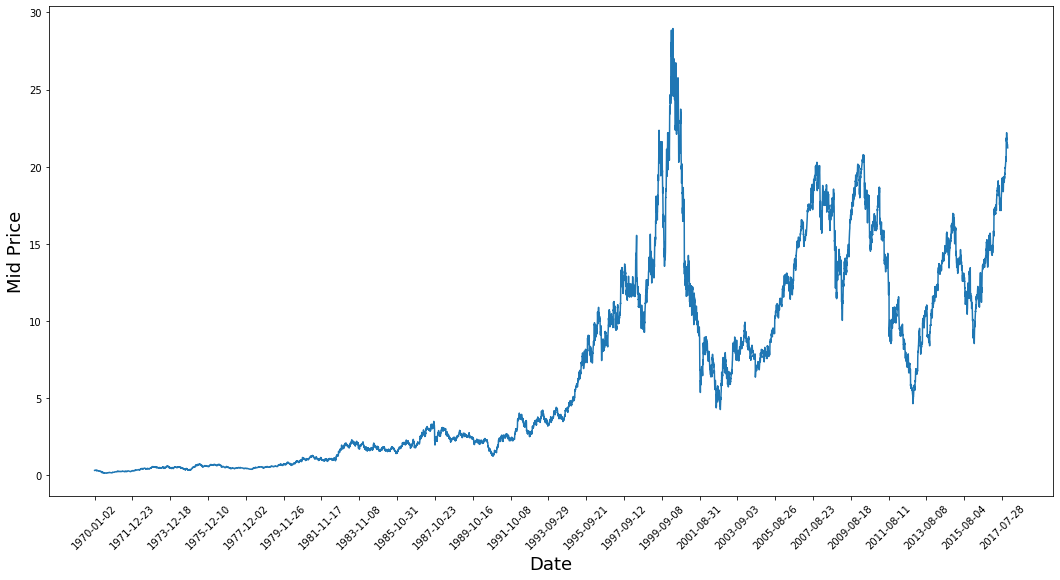

In [0]:
# data visualization

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0, df.shape[0],500), df['Date'].loc[::500], rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

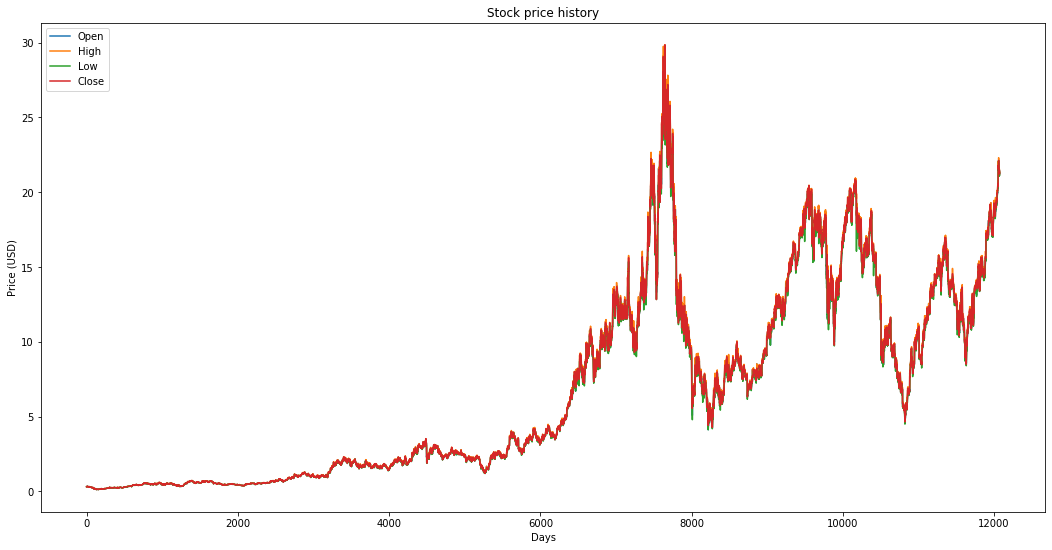

In [0]:
plt.figure(figsize = (18,9))

plt.plot(df["Open"])
plt.plot(df["High"])
plt.plot(df["Low"])
plt.plot(df["Close"])
plt.title('Stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')

plt.show()

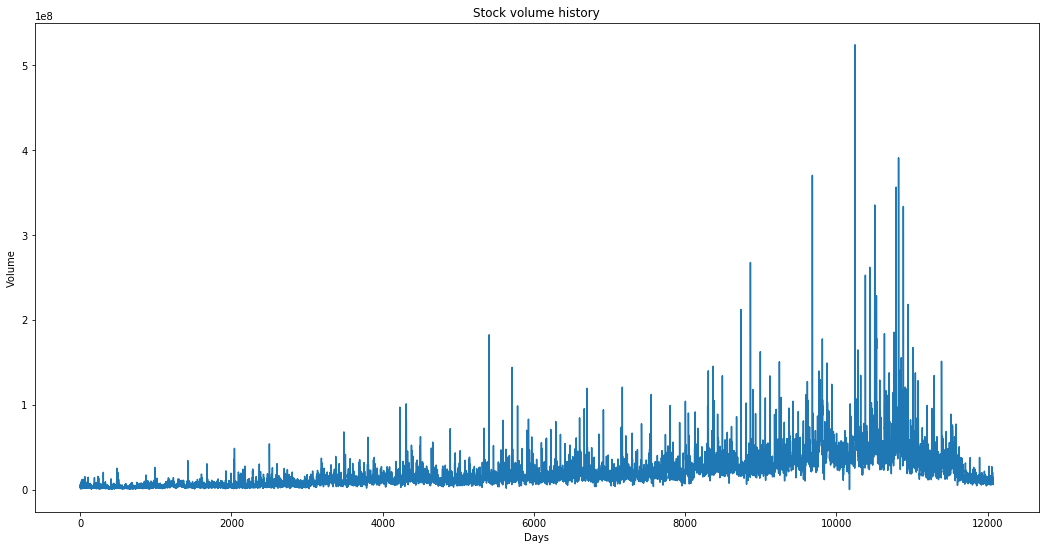

In [0]:
plt.figure(figsize = (18,9))
plt.plot(df["Volume"])
plt.title('Stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')

plt.show()

In [0]:
# calculate the mid prices from the highest and lowest

high_prices = df.loc[:,'High'].as_matrix()
low_prices = df.loc[:,'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# split the data into training set and test set

train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

In [0]:
# data normalization
# scale the data to be between 0 and 1 for both train and test data

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [0]:
# train the Scaler with training data and smooth data
# normalize the data by splitting the full series into windows
# otherwise, the earlier data will not affect the model learning

smoothing_window_size = 2500
# make sure the window size is not too small each window is normalized independently


for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# normalize the last part of remaining data

scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [0]:
# reshape both train and test data
train_data = train_data.reshape(-1)

# normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [0]:
# smooth the data with exponential moving average 
# only smooth the training data

EMA = 0.0
gamma = 0.1

for ti in range(11000):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA

all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [0]:
# averaging mechanisms allow you to predict by representing the future stock price 
# as an average of the previously observed stock prices
# there are two averaging techniques below: standard averaging and exponential moving average
# Below will evaluate both qualitatively and quantitatively 
# to compare the performance(MSE) of the two methods

### Standard Average

In [0]:
# predict the future stock market prices Xt+1 
# as an average of the previously observed data 
# within a fixed size window of t to t−N.

window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00418


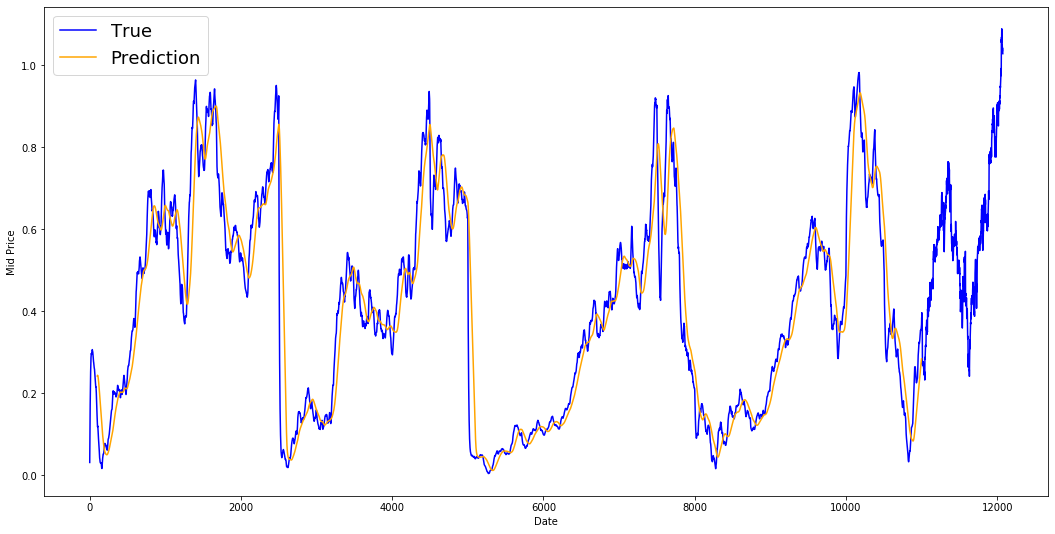

In [0]:
# plotting the results for standard average

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
# plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)

plt.show()

In [0]:
## the prediction of standard average is quite close to the actual value
## means the model is not too bad for very short predictions
## as stock prices don't change dramatically

### Exponential Moving Average

In [0]:
# this method uses a weight to decide the contribution of 
# each time slot of the prediction to EMA
# which allows to preserve much earlier values

window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00003


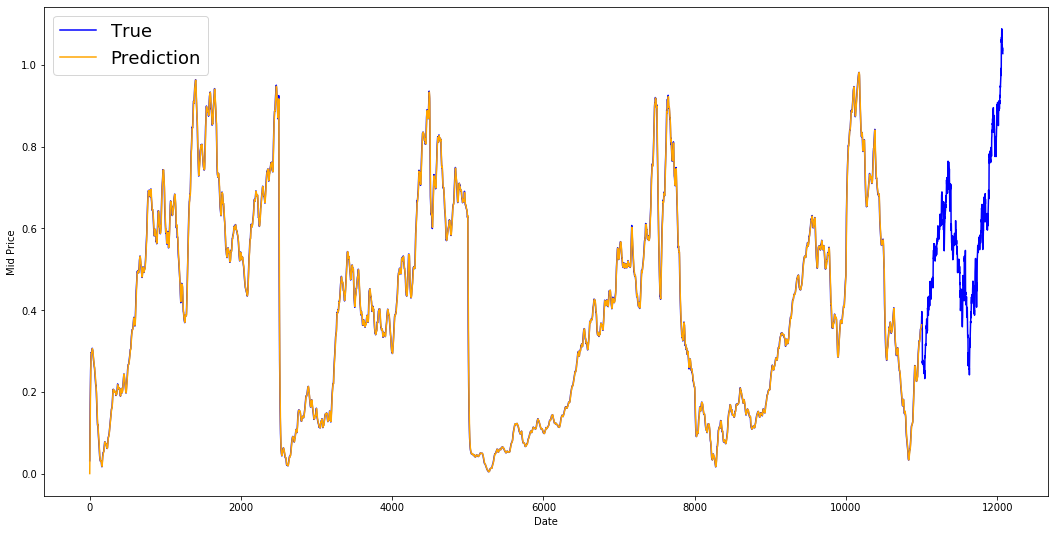

In [0]:
# plotting the results for EMA

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
# plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)

plt.show()

In [0]:
## the EMA performs quite good with a fairly low MSE
## partially because the stock market generally does not change that much overnight
## another drawback of EMA is only getting short period results
## unable to produce longer time frame
## solution: use a more complex model LSTM to deal with times series data

### LSTM Model

In [0]:
# tensorflow's RNN to construct and train a LSTM model
# https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944
# http://karpathy.github.io/2015/05/21/rnn-effectiveness/

In [0]:
# df.describe()

In [8]:
# again split the dataset and normalize for model

train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)

print("Train and Test size", len(df_train), len(df_test))

Train and Test size 9660 2415


In [0]:
# normalization

x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

In [0]:
# x_train

In [0]:
params = {
    "batch_size": 20,  # tried with smaller 5/10 first but didn't perform well
    "epochs": 200,  # nomally converged after 50
    "lr": 0.00010000,
    "time_steps": 40  # tried bigger 60 and had no big difference
}

iter_changes = "dropout_layers_0.4_0.4"

TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()

In [0]:
from tqdm._tqdm_notebook import tqdm_notebook

In [0]:
# converting data to time series

def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat)
    
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    
    return x, y

In [0]:

def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    
    no_of_rows_drop = mat.shape[0]%batch_size
    
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [0]:
# using LSTM from Keras 

In [15]:
from tensorflow import keras
from tensorflow.python.keras.layers import Input, Dense, Dropout,LSTM
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.python.keras import optimizers

In [16]:
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)


length of time-series i/o (9620, 40, 5) (9620,)



length of time-series i/o (2375, 40, 5) (2375,)


In [0]:
# model building

def create_model():
    
    lstm_model = Sequential()
    
    ## (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(60, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(40, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return lstm_model

In [19]:
model = create_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
model_1 = model.fit(x_t, y_t, epochs=50, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 9620 samples, validate on 1180 samples
Epoch 1/50
9620/9620 - 26s - loss: 0.0430 - val_loss: 0.0209
Epoch 2/50
9620/9620 - 24s - loss: 0.0164 - val_loss: 0.0207
Epoch 3/50
9620/9620 - 24s - loss: 0.0037 - val_loss: 0.0214
Epoch 4/50
9620/9620 - 24s - loss: 0.0025 - val_loss: 0.0153
Epoch 5/50
9620/9620 - 24s - loss: 0.0023 - val_loss: 0.0130
Epoch 6/50
9620/9620 - 24s - loss: 0.0021 - val_loss: 0.0089
Epoch 7/50
9620/9620 - 24s - loss: 0.0020 - val_loss: 0.0071
Epoch 8/50
9620/9620 - 24s - loss: 0.0019 - val_loss: 0.0058
Epoch 9/50
9620/9620 - 25s - loss: 0.0018 - val_loss: 0.0053
Epoch 10/50
9620/9620 - 25s - loss: 0.0017 - val_loss: 0.0046
Epoch 11/50
9620/9620 - 24s - loss: 0.0016 - val_loss: 0.0040
Epoch 12/50
9620/9620 - 25s - loss: 0.0016 - val_loss: 0.0034
Epoch 13/50
9620/9620 - 25s - loss: 0.0015 - val_loss: 0.0033
Epoch 14/50
9620/9620 - 25s - loss: 0.0015 - val_loss: 0.0028

In [0]:
?history

In [21]:
# model evaluation

y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.0017437331130787034 (1180,) (1180,)
[0.24462348 0.24516258 0.24566028 0.24638295 0.24724296 0.25083765
 0.25556305 0.26084924 0.26622579 0.27125335 0.276621   0.2816316
 0.28718346 0.291439   0.297332  ]
[0.22171475 0.22305292 0.22050435 0.22587719 0.25408292 0.25234801
 0.26202114 0.26175889 0.26671481 0.26684594 0.26444195 0.26980806
 0.27731928 0.27627363 0.27828088]


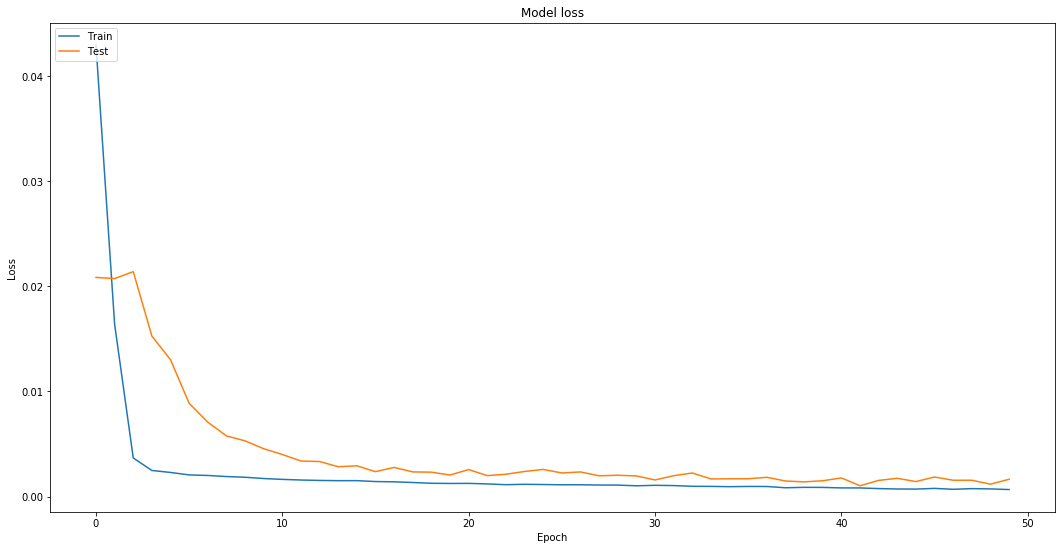

In [22]:
# visualizing the training data

plt.figure(figsize=(18,9))
plt.plot(model_1.history['loss'])
plt.plot(model_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [0]:
## we can see the model performance varies from epoch to epoch
## the error reduced with more training both for test and training data
## now we use the model to predict and visualize the prediction

In [23]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)

print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[7.3904557 7.4064894 7.4212923 7.442786  7.4683647 7.5752788 7.715822
 7.873045  8.032955  8.182486  8.342133  8.491158  8.656282  8.78285
 8.958122 ]
[6.7091 6.7489 6.6731 6.8329 7.6718 7.6202 7.9079 7.9001 8.0475 8.0514
 7.9799 8.1395 8.3629 8.3318 8.3915]


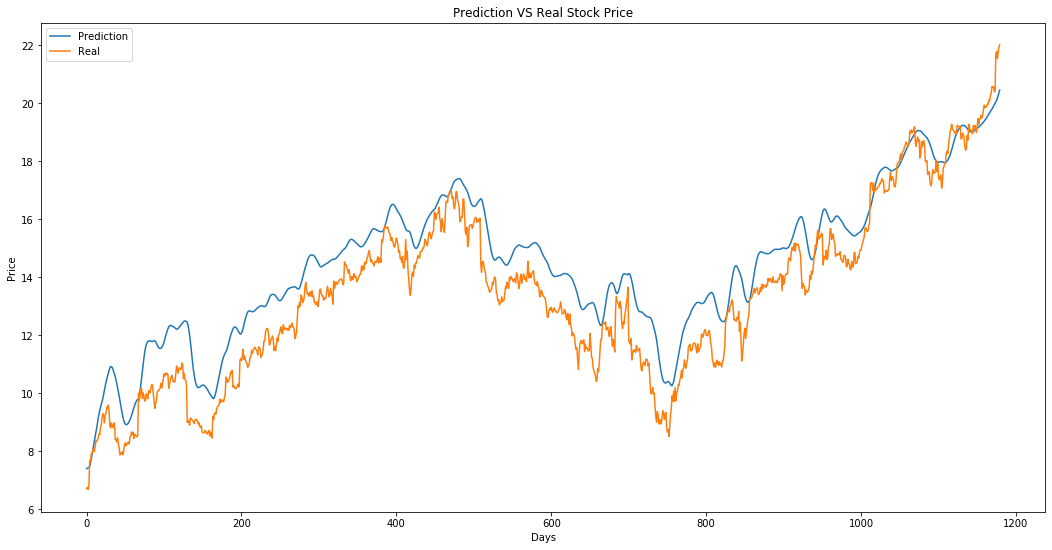

In [24]:
# visualizing the prediction

plt.figure(figsize=(18,9))
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction VS Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')

plt.show()

From above we can see that the loss is quite low however the prediction still has room to improve, although the last bit of the trend is kind of unusal and would be too bold for the model to predict. In the future, we can always add more layers to LSTM model or adjust the batch size or time steps to improve model performance.